In [1]:
import re
import os
import cv2
import glob
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
print(K.tensorflow_backend._get_available_gpus())

from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import average_precision_score

import matplotlib.pylab as plt

from models.net_models import resnet50_model
from utils import randomShiftScaleRotate, randomHorizontalFlip

%matplotlib inline

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
model_name = 'hadamard_resnet50'
load_weight = True
balance = False
input_size = 197
batch_size = 32
epochs = 4

In [3]:
data_dir = '/disk/landmark_rec/'

if balance:
    train_df = pd.read_csv(os.path.join(data_dir, 'balanced_train.csv'))

    # Landmark_id mapping (if id is not continuous)
    train_df['landmark_id'] = train_df['landmark_id'].astype('category')
    id_map = dict(enumerate(train_df['landmark_id'].cat.categories))
    train_df['landmark_id'] = train_df['landmark_id'].cat.codes
    print('`landmark_id` label encode completed.')
    num_class = len(id_map)

    with open(os.path.join(data_dir, 'landmark_id_map.json'), 'w') as file:
        json.dump(id_map, file)
else:
    train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
    # Remove download failed datas
    all_ids = [re.sub('.jpg', '', os.path.basename(file_id)) for file_id in glob.glob(data_dir+'train/*.jpg')]
    train_df = train_df.loc[train_df['id'].isin(all_ids)]
    
    if False:
        landmark_id_cnt = train_df['landmark_id'].value_counts()
        trunc_id = landmark_id_cnt.iloc[2048:].index
        train_df['landmark_id'].loc[train_df['landmark_id'].isin(trunc_id)] = 99999
        train_df = pd.concat([train_df.loc[train_df['landmark_id'] != 99999], 
                              train_df.loc[train_df['landmark_id'] == 99999].sample(frac=0.01)], axis=0)
        train_df = train_df.sample(frac=1)
        train_df.reset_index(drop=True, inplace=True)
        
        # Landmark_id mapping (if id is not continuous)
        train_df['landmark_id'] = train_df['landmark_id'].astype('category')
        id_map = dict(enumerate(train_df['landmark_id'].cat.categories))
        train_df['landmark_id'] = train_df['landmark_id'].cat.codes
        print('`landmark_id` label encode completed.')        
          
    num_class = len(train_df['landmark_id'].unique())
    
    # Put emphasis on rare events at last epoch
    if False:
        rare_id = train_df['landmark_id'].value_counts()
        rare_id = rare_id.loc[rare_id <= 2].index
        rare_df = train_df.loc[train_df['landmark_id'].isin(rare_id)]
    
print('Number of images in training: {}'.format(len(train_df)))
train_df.head()

Number of images in training: 1217876


,id,url,landmark_id
0,cacf8152e2d2ae60,http://static.panoramio.com/photos/original/70...,4676
1,0a58358a2afd3e4e,http://lh6.ggpht.com/-igpT6wu0mIA/ROV8HnUuABI/...,6651
2,6b2bb500b6a38aa0,http://lh6.ggpht.com/-vKr5G5MEusk/SR6r6SJi6mI/...,11284
3,b399f09dee9c3c67,https://lh3.googleusercontent.com/-LOW2cjAqubA...,8429
4,19ace29d77a5be66,https://lh5.googleusercontent.com/-tnmSXwQcWL8...,6231


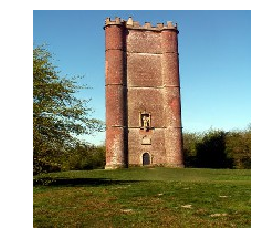

In [4]:
lm_id = train_df['id'].iloc[np.random.randint(len(train_df))]
lm_id = re.findall('^[a-zA-Z0-9]+', lm_id)[0]
img = cv2.imread(data_dir+'train/{}.jpg'.format(lm_id))

plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
def train_generator():
    while True:
        for start in range(0, len(train_X), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(train_X))
            train_X_batch = train_X[start:end]
            train_y_batch = train_y[start:end]
            for id_, y in zip(train_X_batch.values, train_y_batch.values):
                id_ = re.findall('^[a-zA-Z0-9]+', id_)[0]
                img = cv2.imread(os.path.join(data_dir, 'train/{}.jpg'.format(id_)))
                img = cv2.resize(img, (input_size, input_size))
                img = randomShiftScaleRotate(img, p=0.6)
                img = randomHorizontalFlip(img, p=0.7)
                
                pred_y = np.zeros(num_class)
                pred_y[y] = 1                
                x_batch.append(img)
                y_batch.append(pred_y)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.int)
            yield x_batch, y_batch


def valid_generator():
    while True:
        for start in range(0, len(valid_X), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(valid_X))
            valid_X_batch = valid_X[start:end]
            valid_y_batch = valid_y[start:end]
            for id_, y in zip(valid_X_batch.values, valid_y_batch.values):
                id_ = re.findall('^[a-zA-Z0-9]+', id_)[0]
                img = cv2.imread(os.path.join(data_dir, 'train/{}.jpg'.format(id_)))
                img = cv2.resize(img, (input_size, input_size))
                
                pred_y = np.zeros(num_class)
                pred_y[y] = 1
                x_batch.append(img)
                y_batch.append(pred_y)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.int)
            yield x_batch, y_batch

In [6]:
K.clear_session()
if load_weight:
    model = resnet50_model(num_classes=num_class, 
                           weight_path=os.path.join(data_dir, 'weights/{0}.hdf5'.format(model_name)), 
                           learning_rate=0.0001)
else:
    model = resnet50_model(num_classes=num_class, weight_path=None, learning_rate=0.0001)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 197, 197, 3)       12        
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
hadamard_classifier_1 (Hadam (None, 14951)             14952     
_________________________________________________________________
activation_50 (Activation)   (None, 14951)             0         
Total params: 23,602,676
Trainable params: 23,549,550
Non-trainable params: 53,126
___________________________________________________________

In [7]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=3,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=1,
                               verbose=1,
                               epsilon=1e-3),
             ModelCheckpoint(monitor='val_loss',
                             filepath=os.path.join(data_dir, 'weights/{0}.hdf5'.format(model_name)),
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='logs')]

In [8]:
# Train with 5 folds cv
kfolds = KFold(n_splits=5)

for train_idx, valid_idx in kfolds.split(train_df['id']):
    train_X, train_y = train_df['id'].iloc[train_idx], train_df['landmark_id'].iloc[train_idx]
    valid_X, valid_y = train_df['id'].iloc[valid_idx], train_df['landmark_id'].iloc[valid_idx]
    
    model.fit_generator(generator=train_generator(),
                        steps_per_epoch=np.ceil(float(len(train_X)) / float(batch_size)),
                        epochs=epochs,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=valid_generator(),
                        validation_steps=np.ceil(float(len(valid_X)) / float(batch_size)))

Epoch 1/4
30447/30447 [==============================] - 7807s 256ms/step - loss: 5.7862 - acc: 0.3178 - val_loss: 8.1858 - val_acc: 0.2683
Epoch 2/4
30447/30447 [==============================] - 7723s 254ms/step - loss: 3.0227 - acc: 0.5587 - val_loss: 2.7246 - val_acc: 0.5976
Epoch 3/4
30447/30447 [==============================] - 7668s 252ms/step - loss: 2.1201 - acc: 0.6650 - val_loss: 2.0909 - val_acc: 0.6623
Epoch 4/4
30447/30447 [==============================] - 7669s 252ms/step - loss: 1.6832 - acc: 0.7218 - val_loss: 1.8624 - val_acc: 0.7032
Epoch 1/4
30447/30447 [==============================] - 7669s 252ms/step - loss: 1.4208 - acc: 0.7577 - val_loss: 1.5325 - val_acc: 0.7421
Epoch 2/4
30447/30447 [==============================] - 7683s 252ms/step - loss: 1.1962 - acc: 0.7891 - val_loss: 1.4726 - val_acc: 0.7535
Epoch 3/4
30447/30447 [==============================] - 7675s 252ms/step - loss: 1.0378 - acc: 0.8121 - val_loss: 1.4133 - val_acc: 0.7620
Epoch 4/4
30447/3044

In [36]:
train_idx = []
train_df.reset_index(drop=True, inplace=True)

for id_ in range(num_class):
    
    sample_idx = train_df.loc[train_df['landmark_id']==id_].sample(15, replace=True).index
    train_idx = np.append(train_idx, sample_idx)

train_idx = set(train_idx)
train_idx, valid_idx = list(train_idx), list(set(train_df.index) - train_idx)

train_idx, valid_idx = np.array(train_idx, np.int), np.array(valid_idx, np.int)
valid_idx = valid_idx[np.random.randint(0, len(valid_idx), 10000).tolist()]

In [37]:
# Train all classes in one time
train_X, train_y = train_df['id'].iloc[train_idx], train_df['landmark_id'].iloc[train_idx]
valid_X, valid_y = train_df['id'].iloc[valid_idx], train_df['landmark_id'].iloc[valid_idx]
    
model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(train_X)) / float(batch_size)),
                    epochs=10,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=valid_generator(),
                    validation_steps=np.ceil(float(len(valid_X)) / float(batch_size)))

Epoch 1/10
4256/4256 [==============================] - 1110s 261ms/step - loss: 1.5710 - acc: 0.7460 - val_loss: 0.8652 - val_acc: 0.8122
Epoch 2/10
4256/4256 [==============================] - 1008s 237ms/step - loss: 1.3086 - acc: 0.7880 - val_loss: 1.0718 - val_acc: 0.7816
Epoch 3/10
4256/4256 [==============================] - 1010s 237ms/step - loss: 1.1614 - acc: 0.8141 - val_loss: 1.0322 - val_acc: 0.7921

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 4/10
4256/4256 [==============================] - 1013s 238ms/step - loss: 0.8127 - acc: 0.8891 - val_loss: 0.6701 - val_acc: 0.8774
Epoch 5/10
4256/4256 [==============================] - 1020s 240ms/step - loss: 0.7221 - acc: 0.9129 - val_loss: 0.6442 - val_acc: 0.8818
Epoch 6/10
4256/4256 [==============================] - 1004s 236ms/step - loss: 0.6932 - acc: 0.9197 - val_loss: 0.6994 - val_acc: 0.8777
Epoch 7/10
4256/4256 [==============================] - 1012s 238ms/step - loss: 0.67